## สำรวจความนิยมของเหล่าไอดอล BNK48 แบบ real-time จาก Twitter's hashtags ด้วย Python

สำหรับคนที่สนใจเพียงแค่ผลการจับลำดับความนิยมของสาวๆ BNK48 ที่ได้จาก code ก็อ่านเพียงแค่หัวข้อนี้กับหัวข้อถัดไปและข้ามไปดูส่วน conclusion ที่มีตัว video บันทึกภาพการจัดลำดับความนิยมของสมาชิกวงจากการทำ Twitter streaming ที่ส่วนล่างสุดของ post นะครับ

post นี้จะไม่ลงรายละเอียดมาก เหมาะสำหรับผู้เขียน Python เป็นอยู่แล้ว และอยากศึกษาการทำ data streaming แบบง่ายๆ โดยเป็นการแสดงตัวอย่างขั้นตอน ในการใช้ Python 
1. การดึงข้อมูลจาก Twitter
2. การ Streaming และการจัดการข้อมูล
3. การทำหน้าจอแสดงผลแบบ realtime อย่างง่ายๆ

โปรเจ็คนี้ต่อยอดมาจากเนื้อหาเรื่องการจัดการ streaming data ด้วย Pyspark (Python's library for distributed computing) จากคอร์ส [Spark and Python for Big Data with PySpark](https://www.udemy.com/spark-and-python-for-big-data-with-pyspark/) บน [Udemy](https://www.udemy.com/) 

## Twitter กับ BNK48
คาดว่าทุกคนน่าจะรู้จัก Twitter กันอยู่แล้ว ก็ขอบอกเพียงว่า Twitter นี่เป็น platform ที่เหมาะกับผู้ที่อยากฝึกทำ data streaming มากๆ ทั้งเรื่อง API support และ supply of data ที่ล้นเหลือ

จากนั้นผู้เขียนก็มาคิดดูว่า data ชุดไหนที่น่าสนใจจะดึงมาลองเล่นดูและมีผู้พูดถึงอยู่เรื่อยๆ (continuous supply of data) ก็สรุปว่าจะเลือกสำรวจข้อความบน Twitter (tweets) ที่เกี่ยวกับกลุ่มไอดอลหญิงของไทยที่มาแรงและมีกลุ่มผู้ติดตามใน Twitter เป็นจำนวนมาก ไอดอลกลุ่มนี้ก็คือ BNK48

ทีนี้เราก็มารู้จักกับสาวๆ BNK48 กันสักเล็กน้อย สั้นๆ ก็คือ -- "BNK48 เป็นกลุ่มไอดอลหญิงของประเทศไทย และเป็นวงน้องสาวของกลุ่มไอดอลญี่ปุ่น AKB48 ภายใต้แนวคิดร่วมกันคือ "ไอดอลที่คุณสามารถไปพบได้" (จาก [Wikipedia](https://th.wikipedia.org/wiki/%E0%B8%9A%E0%B8%B5%E0%B9%80%E0%B8%AD%E0%B9%87%E0%B8%99%E0%B9%80%E0%B8%84%E0%B9%82%E0%B8%9F%E0%B8%A3%E0%B9%8C%E0%B8%95%E0%B8%B5%E0%B9%80%E0%B8%AD%E0%B8%95)) 

ฝากภาพเหล่าสมาชิก BNK48 ไว้เป็นที่ระลึก(ขอบคุณภาพจาก http://www.metalbridges.com/bnk48/)
![BNK48](BNK48.jpg)


## Techical part 0 -- Workflow

ก่อนเริ่มส่วน technical ก็มาดู workflow กันก่อน สั้นๆ เราก็จะทำการ 
1. ดึงข้อมูลจาก Twitter ด้วย Tweepy
2. Streaming และการจัดการข้อมูล DataFrame ด้วย Pyspark
3. ทำหน้าจอแสดงผลแบบ real-time อย่างง่ายๆ บน Jupyter Notebook โดยใช้ pandas + matplotlib

ซึ่งจริงๆ แล้วในขั้นที่ 2 เราจะใช้ pandas เลยก็ทำได้ และน่าจะสะดวกกว่าเสียด้วยซ้ำ แต่เราใช้ Pyspark เพื่อสาธิต workflow แบบง่ายๆ ที่จะสามารถนำไปต่อยอดในกรณีที่ต้องการใช้ cluster computation เมื่อต้องจัดการกับข้อมูลขนาดใหญ่

ส่วนในขั้นที่ 3 ก็เพียงแค่ทำ while-loop มาครอบ code ที่ใช้ทำกราฟเท่านั้นเอง

**environment ที่ใช้**
* python 3.5.2
* jupyter 4.4.0
* tweepy 3.5.0
* pyspark 2.2.0
* pandas 0.21.0
* matplotlib 2.1.0

## Techical part 1 -- ดึงข้อมูลจาก Twitter ด้วย Tweepy

สำหรับผู้ที่ไม่เคยมี account กับ Twitter ก่อนอื่นก็ต้องสร้าง Twitter account ก่อนนะครับ

เมื่อมี Twitter account แล้ว ก็เข้าไปที่นี่ https://apps.twitter.com/ แล้วก็ login ตามกระบวนการปกติครับ จะเห็นหน้าต่างประมาณนี้

<img src="twitterApp_01.png" alt="twitterApp_firstPage" style="width: 700px;"/>

จากนั้นก็เลือก **Create New App** เพื่อสร้างตัว Twitter app ที่เราจะใช้เป็นตัวกลางในการ Streaming ข้อมูล จาก Twitter -- เติมแค่ fields ที่จำเป็นต้องเติมก็พอ (ตรง Website ใส่เว็บตัวเองหรือ placeholder เช่น https://www.google.com ไปก็ได้)

<img src="twitterApp_02.png" alt="twitterApp_createApp" style="width: 700px;"/>

เมื่อสร้าง app แล้ว ก็เข้าไปดูใน app นั้น จากนั้นเลือก **Keys and Access Tokens** โดยในหน้านี้จะมี 4 fields ที่เราจะนำค่าออกมาใช้ผูกกับ code ของเราเพื่อเรียกข้อมูล ประกอบด้วย Consumer Key (API Key), Consumer Secret (API Secret), Access Token, Access Token Secret

<img src="twitterApp_03.png" alt="twitterApp_keys" style="width: 700px;"/>

#### หลังจากนั้นก็สร้างและบันทึก a Python script ตามไฟล์ที่แนบไว้นี้ครับ (ในตัวอย่างตั้งชื่อว่า streamingTwitterTags.py)

ส่วนที่แต่ละคนต้องปรับเองคือ บรรทัดที่ 12-15 โดยเติม consumer_key, consumer_secret, access_token, และ access_secret ของตัวเองลงไปครับ (บรรทัดที่ 54 จะเปลี่ยนหรือไม่เปลี่ยนก็ตามสะดวกครับ, บรรทัดที่ 52 ก็ต้องเปลี่ยนหากไม่ต้องการให้ script ประมวลบน local host ครับ, บรรทัดที่ 45 ตั้งเป็น 'bnk48' ที่เราจะใช้เป็น keyword สำหรับคัดกรอง)

In [ ]:
# create a file -- streamingTwitterTags.py

# import modules
import tweepy
from tweepy import OAuthHandler, Stream
from tweepy.streaming import StreamListener
import socket
import json


# create credential variables
consumer_key = 'your_consumer_key'        # put your consumer_key from Twitter API
consumer_secret = 'your_consumer_secret'  # put your consumer_secret from Twitter API
access_token = 'your_access_token'        # put your access_token from Twitter API
access_secret = 'your_access_secret'      # put your access_secret from Twitter API

# create a class that listens to tweets
class TweetListener(StreamListener):
    def __init__(self, csocket):
        self.client_socket = csocket
        
    def on_data(self, data):
        try:
            msg = json.loads(data)
            print(msg['text'].encode('utf-8'))
            self.client_socket.send(msg['text'].encode('utf-8'))
            return True
        except BaseException as e:
            print('Error', e)
        return True
    
    def on_error(self, status):
        print(status)
        return True


# create a function that operate on streamed data
def sendData(c_socket):
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    twitter_stream = Stream(auth, TweetListener(c_socket))
    # set a filter to track tweets with a string in the filter set
    twitter_stream.filter(track=['#BNK48'])
    

# execute if 'main'
if __name__ == '__main__':
    s = socket.socket()
    # set the host to be a localhost
    host = '127.0.0.1' 
    # set the connection port to be 5555
    port = 5555
    s.bind((host, port))
    
    print('listening on port:', port)
    
    s.listen()
    c, addr = s.accept()
    
    sendData(c)

ตอนนี้เราก็ได้ script ที่จะใช้ดึงข้อมูลจาก Twitter แล้วครับ ต่อไปก็เป็นการเตรียม PySpark code สำหรับทำ data streaming ครับ

## Technical part 2 -- Streaming และการจัดการข้อมูล DataFrame ด้วย Pyspark

ผู้เขียนเตรียม code สำหรับ streaming data บน Jupyter Notebook โดยใช้ PySpark ดังส่วนข้างล่างครับ
มีกระบวนการโดยสรุปก็คือ
* บรรทัดที่ 5: สร้าง SparkSession
* บรรทัดที่ 8: เชื่อมต่อ streaming socket โดยให้กรอกค่า "host" และ ค่า "port" ที่เราตั้งไว้ตามบรรทัดที่ 52 และ 54 ใน streamingTwitterTags.py
* บรรทัดที่ 10-22: จัดการข้อมูล twitter streaming โดยค่าบนบรรทัดที่ 22 คือ PySpark DataFrame ที่เรียงลำดับ hashtags ทั้งหมดจากมากลงไปหาน้อยโดยเก็บข้อมูลจาก tweets ทั้งหมดที่มีคำว่า '#bnk48' อยู่ (ตั้งไว้ที่บรรทัดที่ 45 ใน streamingTwitterTags.py)
* บรรทัดที่ 25-26: บันทึกเวลาและเริ่มการ streaming โดยให้ผลลัพธ์บันทึกไว้ใน table ชื่อ "topTagsTable"

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, split, explode, substring, count
from datetime import datetime

spark = SparkSession.builder.appName('streamTwitterTags').getOrCreate()

# get tweets
tweets = spark.readStream.format("socket").option("host", "127.0.0.1").option("port", 5555).load()

# convert to lowercase and split the words
words_train = tweets.select(split(lower(tweets.value), " ").alias("value"))

# 'explode' a list of words into rows with single word
words_df = words_train.select(explode(words_train.value).alias('word_explode'))

# keep only rows that the word starts with '#'
hashtags = words_df.filter(substring(words_df.word_explode,0,1)=='#')
hashtags = hashtags.select(hashtags.word_explode.alias('hashtag'))

# count hashtags
count_hashtags = hashtags.groupBy('hashtag').count()
count_hashtags_order = count_hashtags.orderBy(count_hashtags['count'].desc())

# start streaming
start_time = datetime.now()
query = count_hashtags_order.writeStream.outputMode("complete").format("memory").queryName("topTagsTable").start()

เมื่อเรามีทั้ง script สำหรับทำการ streaming tweets (streamingTwitterTags.py) และ script สำหรับจัดการข้อมูลบน Jupyter Notebook แล้ว เราก็พร้อมที่จะทดสอบระบบ โดยเริ่มจากสั่ง run script สำหรับ streaming ก่อน

<img src="twitterStreaming_run.png" alt="twitterStreaming_run" style="width: 700px;"/>

จากนั้นก็ run code PySpark บน Jupyter Notebook เท่านี้ code ของเราเริ่มดึง tweets จาก Twitter มาจัดการสร้าง DataFrame
ถ้าอยากจะรู้ว่า ณ ขณะนั้นๆ DataFrame ของเราหน้าตาเป็นยังไงก็เรียกดูได้ด้วยคำสั่ง

In [77]:
import socket

s = socket.socket()
host = '127.0.0.1' # needs to be in quote
port = 5555
s.connect((host, port))

s.recv --> the command retrieves streaming text upto to the set buffersize. If the text size in momery is larger than the set buffersize, the remaining part is retrieved when the .recv is called again.

In [43]:
tweet = s.recv(10000)
tweet_str = tweet.decode("utf-8")
tweet_str

'เอียด และเล่นกิจกรรมที่นี่ → https://t.c…RT @kamicherprang: เฌอปรางจะไปจับโปเกม่อน 😂\n#CherprangBNK48 #BNK48 #lovecherprangBNK48 💕 https://t.co/eTWB5p0EjiRT @bnk48official: 【คอนเสิร์ตเดี่ยวเต็มรูปแบบครั้งแรกของ BNK48】\n\nวันที่ : 31 มีนาคม 2561\nเปิดขายบัตร : 3 มีนาคม 2561 เป็นต้นไป\nสถานที่ : ไบ…RT @bnk48official: 【คอนเสิร์ตเดี่ยวเต็มรูปแบบครั้งแรกของ BNK48】\n\nวันที่ : 31 มีนาคม 2561\nเปิดขายบัตร : 3 มีนาคม 2561 เป็นต้นไป\nสถานที่ : ไบ…RT @MusicLibraryTH: 2018 #MusicTop40 สัปดาห์ที่ 5\n\n***Highlight***\nPopular Viewed\n- #วันหนึ่งฉันเดินเข้าป่า - Max Jenmana\nPopular Vote\n- #…เราเสียใจตรงกับวันเรามีเรียนT^T #BNK48RT @bnk48official: 【คอนเสิร์ตเดี่ยวเต็มรูปแบบครั้งแรกของ BNK48】\n\nวันที่ : 31 มีนาคม 2561\nเปิดขายบัตร : 3 มีนาคม 2561 เป็นต้นไป\nสถานที่ : ไบ…RT @bnk48official: 【คอนเสิร์ตเดี่ยวเต็มรูปแบบครั้งแรกของ BNK48】\n\nวันที่ : 31 มีนาคม 2561\nเปิดขายบัตร : 3 มีนาคม 2561 เป็นต้นไป\nสถานที่ : ไบ…RT @Chersicfanpage: โอ้โห้วววว สปอยฟตบบ เฌอสิคคค ออกมาแบบนี้ก็ตายสิคะ ฮืออ มีทั่งซบ ทั

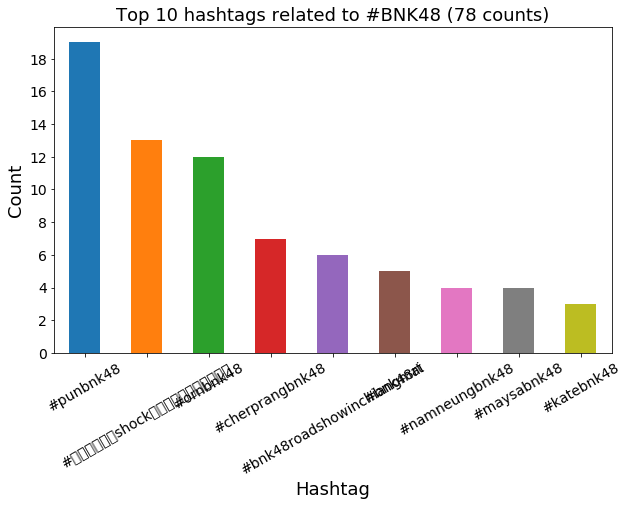

In [128]:
import time
import re
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython import display

%matplotlib inline

i = 0
df = pd.DataFrame([], columns=['hashtags'])

# interactively query in-memory table
while i < 100:
    tweet = s.recv(2048)
    tweet_str = tweet.decode("utf-8",errors='ignore')
    tweet_str
    
    hashtags = [hashtag.lower() for hashtag in re.split('\s+', tweet_str) if len(hashtag)>0 and hashtag[0]=="#"]
    
    temp_df = pd.DataFrame(hashtags, columns=['hashtag'])
    df = pd.concat([df, temp_df])
    results = df.groupby('hashtag')['hashtag'].count().sort_values(ascending=False).reset_index(name='count').head(11)
    
    bnk48_count = results[results['hashtag']=='#bnk48']['count'].values
    
    fig, ax = plt.subplots(1,1,figsize=(10,6)) 
    results[results['hashtag']!='#bnk48'].plot(kind='bar', x='hashtag', y='count', legend=False, ax=ax)
    ax.set_title("Top 10 hashtags related to #BNK48 (%d counts)" % bnk48_count, fontsize=18)
    ax.set_xlabel("Hashtag", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), {"fontsize":14}, rotation=30)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # show only integer yticks
    plt.yticks(fontsize=14)
    plt.show()
    
    time.sleep(1)
    display.clear_output(wait=True)
    i += 1
    

In [129]:
results

,hashtag,count
0,#bnk48,78
1,#punbnk48,19
2,#จันทร์shockโลกปู๊นปู๊น,13
3,#ornbnk48,12
4,#cherprangbnk48,7
5,#bnk48roadshowinchiangmai,6
6,#bnk48rt,5
7,#namneungbnk48,4
8,#maysabnk48,4
9,#katebnk48,3


In [76]:
s.close()

ก็จะเป็นการเรียกข้อมูล hashtags 11 ลำดับแรกขึ้นมา ขั้นตอนนี้อาจต้องรอให้เรา run code ไปสักพัก (ไม่กี่วินาทีก็พอ) ก่อนเพื่อให้มีข้อมูลใน DataFrame มาแสดง ไม่งั้นเราก็จะเห็น DataFrame เปล่าๆ

การเห็น DataFrame ออกมาแบบนี้ก็ดีในระดับนึง แต่จะดียิ่งขึ้นถ้าเรานำข้อมูลที่ streaming นี้มาวาด chart ที่ช่วยแสดงผลแบบ real-time

## Technical part 3 -- ทำหน้าจอแสดงผลแบบ real-time อย่างง่ายๆ บน jupyter notebook

เมื่อเรามีตัว PySpark DataFrame แล้ว วิธีที่จะแสดงผลอย่างง่ายก็คือ แปลงข้อมูลเป็น Pandas DataFrame แล้วใช้ที่สุด Pandas+Matplotlib ช่วยทำ chart ครับ โดยเราอยากให้ chart ของเราคอย update เรื่อยๆ ตามช่วงเวลาที่เรากำหนดไว้

ตัว code ก็มีประมาณนี้ครับ

* บรรทัดที่ 10: ตั้งค่าเวลาที่ต้องการ update ตัว chart ที่จะแสดง โดยในตัวอย่างตั้งให้ update ทุก 10 นาที นับจากเวลาที่เริ่มทำ streaming จาก code ในส่วนก่อนหน้า
* บรรทัดที่ 15-19: ดึงข้อมูล top-hashtag streaming ที่บันทึกไว้ใน PySpark DataFrame มา 11 ลำดับ แล้วแปลงให้เป็น Pandas DataFrame จากนั้นก็นับว่ามี hashtag ว่า '#bnk48' อยู่กี่ครั้ง เพื่อเก็บไว้เป็นตัวอ้างอิง (hashtags 11 ตัวที่ดึงมาจะต้องมีคำว่า '#bnk48' แน่นอน เพราะเป็นคำที่ใช้ในการ filter tweets ส่วนที่เหลืออีก 10 hashtags ก็จะเป็นส่วนที่เราจะมาทำ chart ลำดับความนิยมของ hashtags ที่เกี่ยวข้องกับ '#bnk48')
* บรรทัดที่ 21-22: ให้คอยแสดงค่าเปรียบเทียบเวลาที่เริ่ม streaming และเวลาที่ทำการประมวล chart  
* บรรทัดที่ 24-32: ส่วนนี้เป็นการทำ bar chart เพื่อแสดง 10 ลำดับ hashtags ยอดนิยมที่เกี่ยวเนื่องกับ '#bnk48' ครับ

start time: 2018-01-20 13:03:13
current time: 2018-01-20 13:13:20


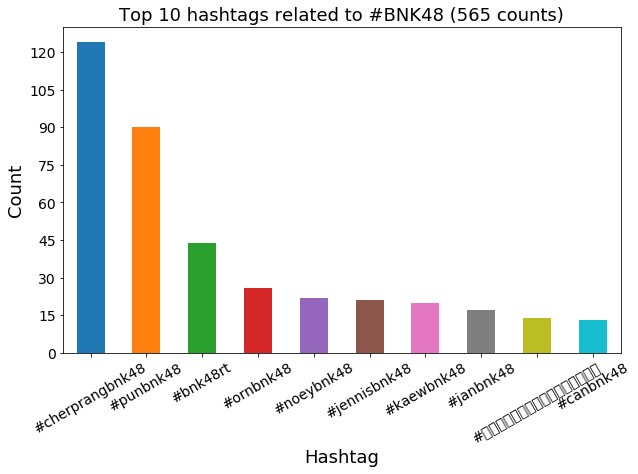

In [2]:
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocatorหลังหลัง
from IPython import display

%matplotlib inline

# interactively query in-memory table
while datetime.now() < (start_time + timedelta(minutes=10)):
    time.sleep( 10 )    
    display.clear_output(wait=True)
    
    top_hashtags_sql = spark.sql("select * from topTagsTable").limit(11)
    
    top_hashtags = top_hashtags_sql.toPandas()

    bnk48_count = top_hashtags[top_hashtags['hashtag']=='#bnk48']['count'].values

    print("start time:", start_time.strftime('%Y-%m-%d %H:%M:%S'))
    print("current time:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    fig, ax = plt.subplots(1,1,figsize=(10,6)) 
    top_hashtags[top_hashtags['hashtag']!='#bnk48'].plot(kind='bar', x='hashtag', y='count', legend=False, ax=ax)
    ax.set_title("Top 10 hashtags related to #BNK48 (%d counts)" % bnk48_count, fontsize=18)
    ax.set_xlabel("Hashtag", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), {"fontsize":14}, rotation=30)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # show only integer yticks
    plt.yticks(fontsize=14)
    plt.show()

## Ready. Set. Go!

หลังจากเรามี code ทุกอย่างเรียบร้อยแล้วก็ทำการ run ทุกอย่างตามที่เขียนไว้ในส่วน **Technical part 2** และ **Technical part 3** ได้เลยครับ

ก็จะได้ chart ออกมาประมาณนี้ โดยตัว chart จะ update ตัวเองเรื่อยๆ ตามเวลา (timedelta) ที่ตั้งไว้

<img src="chart_example.png" alt="chart_example" style="width: 700px;"/>

เมื่อเราทำการ streaming จนพอใจแล้วก็ปิดการ streaming ด้วยคำสั่งนี้ครับ

In [ ]:
## Stop query when done
query.stop()

ปล. อย่าลืมไปปิดตัว terminal ที่รัน python script (streamingTwitterTags.py) เชื่อมต่อกับ Twitter API ด้วยนะครับ

## สรุปผลการสำรวจความนิยมของเหล่าไอดอล BNK48 แบบ real-time ในคืนวัน Valentine

ผู้เขียนได้ทำการรัน code ที่เราทำขึ้นในคืนวัน Valentine ช่วงเวลา 20.00-21.00 นะครับ

เรามาดูกันว่าสาวๆ BNK48 คนไหนบ้างที่มีชาว Twitter พูดถึงกันมากที่สุดในช่วงหัวค่ำของวันแห่งความรัก

![Animated ranking results](output.gif)

จากไฟล์ภาพนะครับ เราก็จะเห็นว่าในตอนเริ่มต้นการ streaming 

บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย


## ส่งท้าย

จบแล้วครับสำหรับการทำ code และตัวอย่างการสำรวจความนิยมของสาวๆ BNK48 โดยใช้ Twitter API, PySpark, และ Pandas+Matplotlib

เป็นไงบ้างครับ โอชิใครขึ้นแท่นสมาชิกสุดฮอทของวงบ้าง โอชิใครหลุดลำดับไปก็ชวนเพื่อนๆ ไปช่วยกันทำคะแนนความนิยมเพิ่มได้โดยการไป flood Twitter กันนะครับ XD

![otaku_power](otaku_power.jpg) 
image from https://holyonthenet.webnode.es/news/cafes-cosplay-/

หวังว่าตัวอย่างสนุกๆ นี้จะพอเป็นประโยชน์กับผู้ที่สนใจจะทำ data manipulation หรือ data streaming ด้วย (Py)Spark บ้างนะครับ

หากส่วนไหนผิดพลาดหรือข้อแนะนำเพิ่มเติมตรงไหนก็รบกวนช่วยแจ้งได้เลยนะครับ ขอบคุณครับผม